In [2]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] =28.0
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np
import loadMWSnap as mws
import velocitySpectroscopy as vs
import healpy as hp

In [3]:
reload(mws);
mx_params = {
    'aperture': 1.0, # effective aperture in cm^2
    'exposure': 300.0, # exposure time in sec
    'sigma_energy': 3.0/(3.5*10**3)/(2.*(2.*np.log(2.))**0.5), # fractional Guassian sigma of the energy response
    'theta_fov': 20.0, # angular radius of the sampling cone in degrees
}
mx_lon = np.array([-105., -85., -65., -45., -25., 0., 25., 45., 65., 85., 105.])[::2]
# Load the particle data
# pos in physical kpc, vel in km/s, mass in physical m_sun
pos, vel, partmass, ldim, data = mws.loadMWSnap(halo=374)

Reading rockstar output /nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo374/rockstar/hlists/hlist_1.00000.list
Reading MUSIC log /nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo374/music.conf_log.txt
Lagrangian patch dimensions are (486, 224, 242)
Reading Gadget snapshot /nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo374/output/snapshot_235


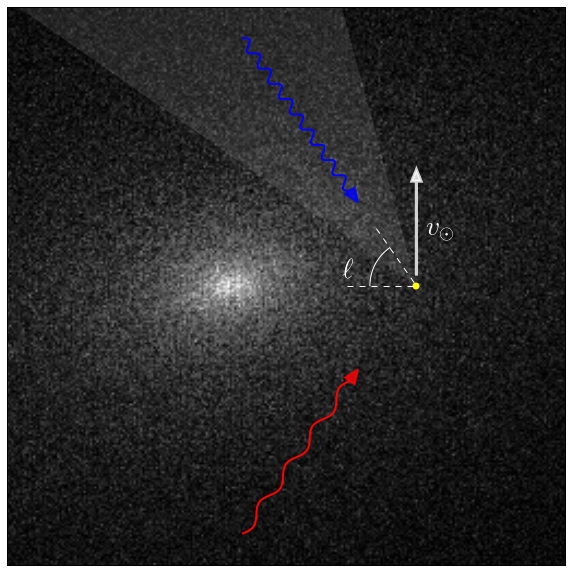

In [158]:
####### Figure of Halo 374 ########
fsz = 10
fig, ax = plt.subplots(1, 1, figsize=(fsz, fsz))
ran = 12.0 #275.7

# hist, xe, ye = np.histogram2d(pos[:,0], pos[:,1], bins=256, range=[[-0.8*ran, 1.2*ran], [-ran, ran]])
imargs = {'cmap': plt.cm.Greys_r, 'origin': 'lower', 'extent': [-0.8*ran, 1.2*ran, -ran, ran]}
# ax.imshow(np.log10(hist), **imargs)
ax.imshow(hist.T, **imargs)

# diagram of velocity spectroscopy
rfov = 200.
rot = -55.
torad = np.pi/180
polyverts = np.array([[0.,0.],[-rfov*np.cos((rot-20.0)*torad),-rfov*np.sin((rot-20.0)*torad)],
                      [-rfov*np.cos((rot+20.0)*torad),-rfov*np.sin((rot+20.0)*torad)]])
polyverts[:,0] += 8.0
fov = Polygon(polyverts, lw=0, color='white', alpha=0.1)
ax.add_patch(fov)
ax.scatter(8.0, 0.0, facecolor='yellow', s=50, lw=0)
ax.arrow(8.0, 0.5, 0.0, 4.0, head_width=0.4, head_length=0.5, lw=3, fc='white', ec='white', alpha=0.8)
ax.text(8.4, 2.0, '$v_\odot$', color='white')

cs = np.cos(rot*torad)
sn = np.sin(rot*torad)

# arc
ax.plot([8.0-3, 8.0], [0.0, 0.0], 'w--', lw=1)
ax.plot([8.0-3*cs, 8.0], [-3*sn, 0.0], 'w--', lw=1)
ang = np.linspace(0.0, torad*rot, 30)
ax.plot(8.0-2*np.cos(ang), -2*np.sin(ang), 'w')
ax.text(4.8, 0.3, '$\ell$', color='white')

# blue arrow
arad = 5.0
xpos=np.linspace(0.0, 1.0, 100)
ypos=0.2*np.sin(10*2*np.pi*xpos)
xpos *= apos
xa = -cs*xpos+sn*ypos
ya = -sn*xpos-cs*ypos
xa += 8.0-arad*cs
ya += -sn*arad
ax.plot(xa, ya, lw=2, c='blue')
ax.arrow(8.0-arad*cs, -sn*arad, 0.01*cs, 0.01*sn, head_width=0.5, head_length=0.6, lw=2, fc='blue', ec='blue', alpha=0.8)

# red arrow
xpos=np.linspace(0.0, 1.0, 100)
ypos=0.2*np.sin(4*2*np.pi*xpos)
xpos *= apos
xa = -cs*xpos+sn*ypos
ya = sn*xpos+cs*ypos
xa += 8.0-arad*cs
ya += sn*arad
ax.plot(xa, ya, lw=2, c='red')
ax.arrow(8.0-arad*cs, sn*arad, 0.01*cs, -0.01*sn, head_width=0.5, head_length=0.6, lw=2, fc='red', ec='red', alpha=0.8)

# ax.axis('off')
ax.set_xlim(-0.8*ran, 1.2*ran)
ax.set_ylim(-ran, ran)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_axis_bgcolor('black')

fig.savefig('../img/vspec_diagram.png', bbox_inches='tight', dpi=300)

-0.25923677767 0.409085487658
0.576133638681 0.398524588669


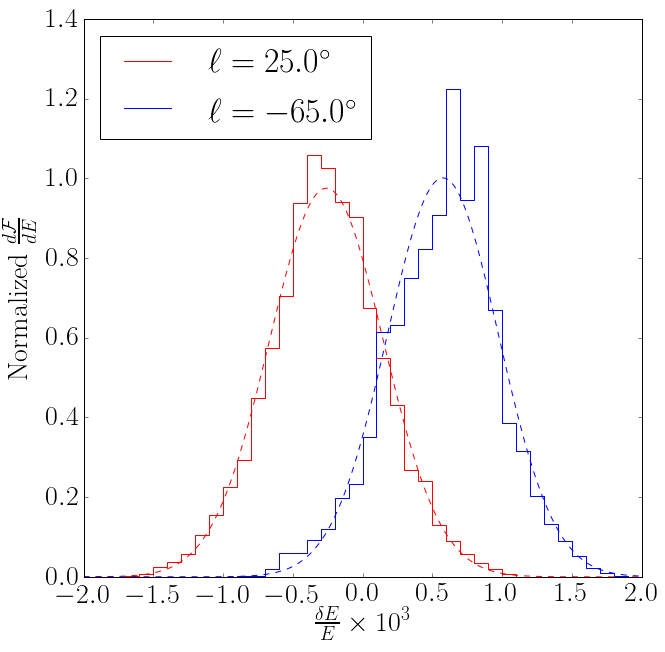

In [64]:
###### comparison of line profile hitograsms to Gaussian models ########
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
def gauss(x, sigma, mu):
    return (2*np.pi*sigma**2)**-0.5 * np.exp(-(x-mu)**2/(2*sigma**2))
ran=2.0
xp = np.linspace(-ran,ran,200)
colors=['red', 'blue']
for i, lon in enumerate([25.0, -65.0]):
    _, v_los, r_los = vsh.sample_los(pos, vel/3.0e5*10**3, lon=lon, lat=25.0, beam_radius=20.0)

    # histogram the bins
    hist, bins = np.histogram(v_los, bins=40, range=(-ran, ran), weights=r_los**-2, density=True)
    bins = 0.5*(bins[1:]+bins[:-1]) # rescale bins to be in terms of fractional energy shift

    # Gaussian model parameters
    center = np.average(v_los, weights=r_los**-2)
    sigma = np.average((v_los-center)**2, weights=r_los**-2)**0.5
    print center, sigma

    ax.plot(bins, hist, '-', drawstyle='steps-mid', label=r'$\ell=%.1f^\circ$'%lon, c=colors[i])
    ax.plot(xp, gauss(xp, sigma, center), '--', c=colors[i])
    
# ax.set_title(r'Observed spectrum')
ax.set_xlabel(r'$\frac{\delta E}{E} \times 10^3$')
ax.set_ylabel(r'Normalized $\frac{d\mathcal{F}}{dE}$')
ax.legend(loc='upper left')

# fig.savefig('../img/dnde_demo.png', bbox_inches='tight')

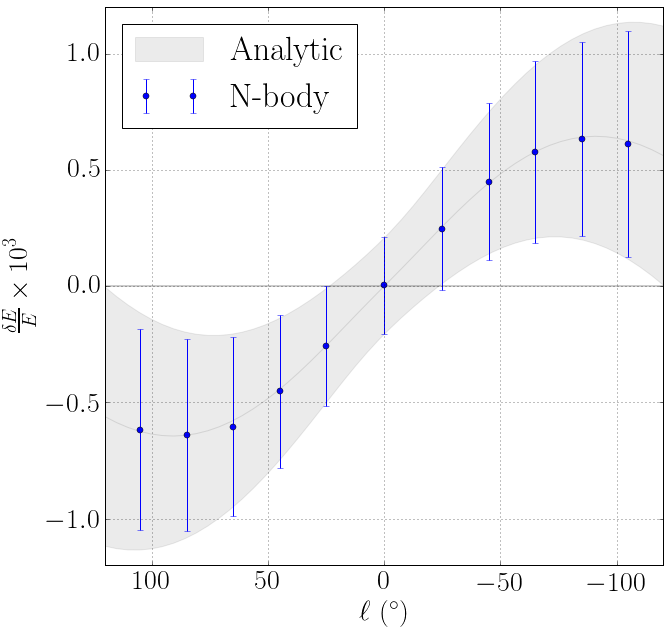

In [4]:
# Plot halo 374 results!
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
h=374
nb = vs.readVSData(h, 'nbody')
an = vs.readVSData(h, 'analytic')
fill = vs.readVSData(h, 'fill')
ax.plot([-120, 120], [0,0], 'k-', lw=0.4)

inds=[0,1,2,3,4,5,6,7,8,9,10]#[0,2,4,6,8,10]
ax.errorbar(nb['l'][inds], nb['centroid'][inds]*10**3,\
            yerr=nb['sigma_centroid'][inds]*10**3, fmt='o', c='blue', label='N-body')

# ax.errorbar(an['l'][inds], an['centroid'][inds]*10**3,\
#             yerr=an['sigma_centroid'][inds]*10**3, fmt='o', c='red', label='Analytic')

flon = fill['l']
cent = fill['centroid']*10**3
plus = cent + fill['sigma_centroid']*10**3
minus = cent - fill['sigma_centroid']*10**3
ax.fill_between(flon, minus, plus, facecolor='black', alpha=0.08, label='Analytic')
ax.plot(flon, cent, 'k-', alpha=0.1)


# frills
# ax.set_title(r'Decay line spectral shift')
ax.set_ylabel(r'$\frac{\delta E}{E} \times 10^3$')
ax.set_xlabel(r'$\ell$ ($^{\circ}$)')
ax.set_xlim(-120., 120.)
ax.invert_xaxis()
ax.set_ylim(-1.2, 1.2)
ax.grid(True)

ax.legend(loc='upper left')

# fig.savefig('../img/de_vs_l_800.png', bbox_inches='tight')
# fig.savefig('../img/de_vs_l_filled.png', bbox_inches='tight')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


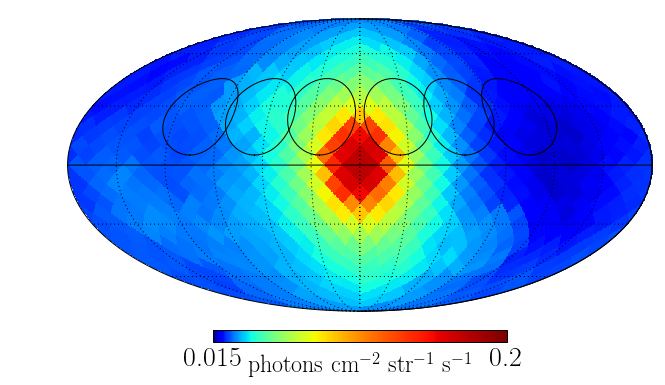

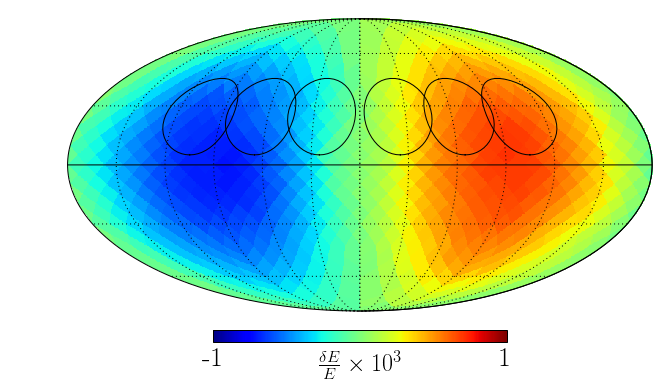

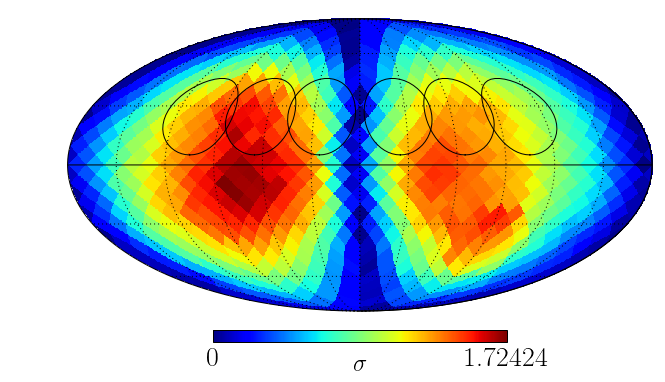

In [69]:
reload(vs);  
hpspec = vs.spectroscopy_healpix(pos=pos, vel=vel, mass=partmass, nside=8, **mx_params)
def plot_beams(lon=[-85., -65., -45., -25., 0.0, 25., 45., 65., 85.], lat=25.0, beamrad=20.0):
    beamargs = {'rot': (180,0,0), 'lonlat': True, 'c': 'black'} 
    bphi = np.linspace(0., 360., 50)
    bthe = (90.0-beamrad)*np.ones_like(bphi)
    for l in lon:
        beamargs['rot'] = (180.0-l, lat, 0.0)
        hp.projplot(bphi, bthe, **beamargs)
def bigger_units():
    f = plt.gcf().get_children()
    CbAx = f[2]
    unit_text_obj = CbAx.get_children()[1]
    unit_text_obj.set_fontsize(24.0)
    unit_text_obj.set_va('top')

# make Moll
mapargs = {'rot': (180,0,0), 'margins': (0,0,0,0)} 

# properly scale flux for astro-h to get number counts
ahs = 1.0*0.37892243899248773*300.0

hp.mollview(hpspec['flux']*ahs**-1, norm='log', title='', min=0.015, max=0.2, \
            unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', **mapargs);
#             unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', flip='geo', **mapargs);
plot_beams(lon=mx_lon)
hp.graticule();
bigger_units()

hp.mollview(hpspec['centroid']*10**3, min=-1.0, max=1.0, title='', \
            unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs);
plot_beams(lon=mx_lon)
hp.graticule();
bigger_units()

hp.mollview(np.abs(hpspec['centroid']/hpspec['sigma_centroid']), min = 0, \
            title='', unit=r'$\sigma$', **mapargs);
plot_beams(lon=mx_lon)
hp.graticule();
bigger_units()

In [68]:
reload(vs);  
hpspec = vs.spectroscopy_healpix(pos, vel, partmass, nside=8)
def plot_beams(lon=[-85., -65., -45., -25., 0.0, 25., 45., 65., 85.], lat=25.0, beamrad=20.0):
    beamargs = {'rot': (180,0,0), 'lonlat': True, 'c': 'black'} 
    bphi = np.linspace(0., 360., 50)
    bthe = (90.0-beamrad)*np.ones_like(bphi)
    for l in lon:
        beamargs['rot'] = (180.0-l, lat, 0.0)
#         hp.projscatter(0, 90.0, **beamargs)
        hp.projplot(bphi, bthe, **beamargs)
    
def bigger_units():
    f = plt.gcf().get_children()
    CbAx = f[2]

    unit_text_obj = CbAx.get_children()[1]
    unit_text_obj.set_fontsize(24.0)
    unit_text_obj.set_va('top')
#     unit_text_obj.set_y(1.0)

# make Moll
mapargs = {'rot': (180,0,0), 'margins': (0,0,0,0)} 

# matplotlib.rcParams['axes.labelsize'] =28.0

# properly scale flux for astro-h to get number counts
ahs = 1.0*0.37892243899248773*300.0

hp.mollview(hpspec['flux'], norm='log', title='', min = .01, max=0.5, \
            unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', **mapargs);
#             unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', flip='geo', **mapargs);
# plot_beams()

# plot_beams(lon=[-65., -25., 25., 65.])
plot_beams(lon=[-105., -65., -25., 25., 65., 105.])
hp.graticule();
bigger_units()
plt.savefig('../img/flux_map_374.png', bbox_inches='tight', pad_inches=0)

hp.mollview(hpspec['centroid']*10**3, min=-1.0, max=1.0, title='', \
            unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs);
# plot_beams(lon=[-65., -25., 25., 65.])
plot_beams(lon=[-105., -65., -25., 25., 65., 105.])
hp.graticule();
bigger_units();
plt.savefig('../img/line_map_374.png', bbox_inches='tight', pad_inches=0)

# hp.mollview(hpspec['sigma_centroid']*10**3, title='Centroid uncertainty', \
#             unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs)
# hp.graticule();

hp.mollview(np.abs(hpspec['centroid']/hpspec['sigma_centroid'])*ahs**0.5, min = 0, max=3, \
            title='', unit=r'$\sigma$', **mapargs);
# plot_beams(lon=[-65., -25., 25., 65.])
plot_beams(lon=[-105., -65., -25., 25., 65., 105.])
hp.graticule();
bigger_units();
plt.savefig('../img/sigma_map_374.png', bbox_inches='tight', pad_inches=0)


TypeError: only length-1 arrays can be converted to Python scalars

In [12]:
'''
An example plot to show how sampling is done

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
zoom = 800 # kpc
ax.set_xlim([-0.5*zoom, 0.5*zoom])
ax.set_ylim([-0.5*zoom, 0.5*zoom])
ax.set_title(r'MW halo: Sampling the FOV')
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
cpos, _, _ = vsh.sample_los(pos, vel, beam_radius=20.0)
sfilt = np.abs(pos[:,2]) < 1.0 # filter all particles into a thin 1 kpc slab to make plotting easier
ax.scatter(pos[sfilt][:,0], pos[sfilt][:,1], s=0.5, c='black', lw=0)
ax.scatter(cpos[:,0], cpos[:,1], s=2.0, c='red', lw=0)
'''

"\n# an example plot to show how sampling is done\n\nfig, ax = plt.subplots(1, 1, figsize=(10, 10))\nzoom = 800 # kpc\nax.set_xlim([-0.5*zoom, 0.5*zoom])\nax.set_ylim([-0.5*zoom, 0.5*zoom])\nax.set_title(r'MW halo: Sampling the FOV')\nax.set_xlabel(r'$x$ [kpc]')\nax.set_ylabel(r'$y$ [kpc]')\ncpos, _, _ = vsh.sample_los(pos, vel, beam_radius=20.0)\nsfilt = np.abs(pos[:,2]) < 1.0 # filter all particles into a thin 1 kpc slab to make plotting easier\nax.scatter(pos[sfilt][:,0], pos[sfilt][:,1], s=0.5, c='black', lw=0)\nax.scatter(cpos[:,0], cpos[:,1], s=2.0, c='red', lw=0)\n"

In [ ]:
'''
Code to test uniformity of 3d rotation sampling.
Looks good!

from mpl_toolkits.mplot3d import Axes3D
fig = matplotlib.pyplot.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection = '3d')

whisk = np.array([[-0.02, 0.0, 1.0], [0.02, 0.0, 1.0]])

for i in xrange(5000):
    rot = vsh.generateRotationMatrix()
    w = np.dot(whisk, rot)
    ax.plot(w[:,0], w[:,1], w[:,2], color = 'b');

ax.set_xlim([-1.1, 1.1]);
ax.set_ylim([-1.1, 1.1]);
ax.set_zlim([-1.1, 1.1]);
'''